# Load Winoground

In [1]:
from datasets import load_dataset
auth_token = "your_token_hereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee"  # Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Found cached dataset winoground (/home/sean/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/72585f4d9cd5a28790bb9bc2adbdd45633f36dfbf85df529e0756e114e134285)


  0%|          | 0/1 [00:00<?, ?it/s]

# Load CLIP

In [2]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Look at an example from Winoground and get the image-caption scores from CLIP

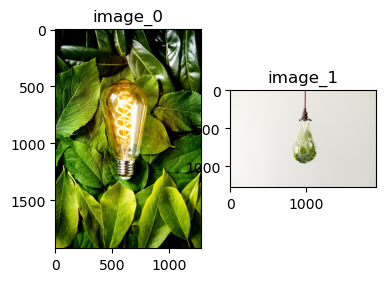

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants

CLIP image-text match scores:
image_0, caption_0: 32.425514221191406
image_0, caption_1: 33.014556884765625
image_1, caption_0: 32.718040466308594
image_1, caption_1: 32.88880157470703


In [3]:
from matplotlib import pyplot as plt

ax1 = plt.subplot(1, 3, 1)
ax1.title.set_text('image_0')
plt.imshow(winoground[155]["image_0"].convert("RGB"))

ax2 = plt.subplot(1, 3, 2)
ax2.title.set_text('image_1')
plt.imshow(winoground[155]["image_1"].convert("RGB"))

plt.show()

print("caption_0:", winoground[155]["caption_0"])
print("caption_1:", winoground[155]["caption_1"])

# Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
# Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
input_c0_i0 = clip_processor(text=[winoground[155]["caption_0"]], images=[winoground[155]["image_0"].convert("RGB")], return_tensors="pt")
input_c1_i0 = clip_processor(text=[winoground[155]["caption_1"]], images=[winoground[155]["image_0"].convert("RGB")], return_tensors="pt")
input_c0_i1 = clip_processor(text=[winoground[155]["caption_0"]], images=[winoground[155]["image_1"].convert("RGB")], return_tensors="pt")
input_c1_i1 = clip_processor(text=[winoground[155]["caption_1"]], images=[winoground[155]["image_1"].convert("RGB")], return_tensors="pt")
output_c0_i0 = clip_model(**input_c0_i0.to(device))
output_c1_i0 = clip_model(**input_c1_i0.to(device))
output_c0_i1 = clip_model(**input_c0_i1.to(device))
output_c1_i1 = clip_model(**input_c1_i1.to(device))
clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
clip_score_c1_i1 = output_c1_i1.logits_per_image.item()

print()
print("CLIP image-text match scores:")
print("image_0, caption_0:", clip_score_c0_i0)
print("image_0, caption_1:", clip_score_c1_i0)
print("image_1, caption_0:", clip_score_c0_i1)
print("image_1, caption_1:", clip_score_c1_i1)

# Get CLIP image-caption scores from the whole dataset

In [4]:
from tqdm import tqdm
winoground_clip_scores = []
for example in tqdm(winoground):
  # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
  # Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
  input_c0_i0 = clip_processor(text=[example["caption_0"]], images=[example["image_0"].convert("RGB")], return_tensors="pt")
  input_c1_i0 = clip_processor(text=[example["caption_1"]], images=[example["image_0"].convert("RGB")], return_tensors="pt")
  input_c0_i1 = clip_processor(text=[example["caption_0"]], images=[example["image_1"].convert("RGB")], return_tensors="pt")
  input_c1_i1 = clip_processor(text=[example["caption_1"]], images=[example["image_1"].convert("RGB")], return_tensors="pt")
  output_c0_i0 = clip_model(**input_c0_i0.to(device))
  output_c1_i0 = clip_model(**input_c1_i0.to(device))
  output_c0_i1 = clip_model(**input_c0_i1.to(device))
  output_c1_i1 = clip_model(**input_c1_i1.to(device))
  clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
  clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
  clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
  clip_score_c1_i1 = output_c1_i1.logits_per_image.item()
  winoground_clip_scores.append({"id" : example["id"], "c0_i0": clip_score_c0_i0, "c0_i1": clip_score_c0_i1, "c1_i0": clip_score_c1_i0, "c1_i1": clip_score_c1_i1})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:52<00:00,  3.56it/s]


# Define the text, image, and group metrics, and compute the overall performance of CLIP

In [5]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

text_correct_count = 0
image_correct_count = 0
group_correct_count = 0
for result in winoground_clip_scores:
  text_correct_count += 1 if text_correct(result) else 0
  image_correct_count += 1 if image_correct(result) else 0
  group_correct_count += 1 if group_correct(result) else 0

denominator = len(winoground_clip_scores)
print("text score:", text_correct_count/denominator)
print("image score:", image_correct_count/denominator)
print("group score:", group_correct_count/denominator)


text score: 0.3075
image score: 0.1025
group score: 0.0825


In [6]:
results = ""

for result in winoground_clip_scores:
    results += f"{result['id']}\tImage score: {image_correct(result)}\tText score: {text_correct(result)}\tGroup score: {group_correct(result)}\n"

with open("winoground_clip_results.txt", "w") as f:
    f.write(results)